In [1]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

import tensorflow as tf
import cv2

In [2]:
os.chdir("../")
from Sources.tools import *

In [5]:
def _parse_function(example):
    """
    A function that maps a tf record to a feature dictionary. 
    Source: https://www.kaggle.com/code/aayushkandpal/ddsm-vgg19/notebook 

    Args:
        example (TFRecord): tf record, a simple format for storing a sequence of binary records

    Returns:
        dict: dictionary of features, 'label', 'label_normal', and 'image'
    """    
    # prepare feature dictionary 
    feature_dictionary = {
        'label': tf.io.FixedLenFeature([], tf.int64),
        'label_normal': tf.io.FixedLenFeature([], tf.int64),
        'image': tf.io.FixedLenFeature([], tf.string)
        }

    parsed_example = tf.io.parse_example(example, feature_dictionary)
    return parsed_example

In [7]:
def read_data(filename,transfer_learning=True):
    """
    A function to read the tfrecods in the DDSTM data set
    Starting point from: https://www.kaggle.com/code/aayushkandpal/ddsm-vgg19/notebook 

    Args:
        filename (string): full path to tfrecord
    """    
    images, labels = [], []

    # Create a TFRecordDataset to read one or more TFRecord files
    full_dataset = tf.data.TFRecordDataset(filename,num_parallel_reads=tf.data.experimental.AUTOTUNE) 
    
    # Save in memory
    full_dataset = full_dataset.cache()

    #drop corrupted files 
    full_dataset = full_dataset.apply(tf.data.experimental.ignore_errors()) 

    # map feature dictionary to each tfrecord in full_dataset
    full_dataset = full_dataset.map(_parse_function, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    # for each image
    for image_features in tqdm(full_dataset, desc="Loading images...", total=sum(1 for _ in full_dataset)):
        # convert image to numpy
        image = image_features['image'].numpy()
        # convert to numeric tensor
        image = tf.io.decode_raw(image_features['image'], tf.uint8)
        # reshape 
        image = tf.reshape(image, [299, 299]) 
        # append reshapes images 
        images.append(image)
        # append labels
        labels.append(image_features['label_normal'].numpy()) # changed from 'label'
    
    return images, labels

# Load data

In [8]:
images, labels = [], []

print("loading data")

image, label = read_data("Data/DDSM/training10_0/training10_0.tfrecords", transfer_learning=True) # tl=True: duplicate image shape so we have three channels 
images.append(image)
labels.append(label)
print("data has been loaded")

# flatten data (images and labels), so they are not nested lists
images = [i for image in images for i in image]
labels = [l for label in labels for l in label]

# define train and test
X=np.array(images)
y=np.array(labels)

loading data


Loading images...: 100%|██████████| 11177/11177 [00:02<00:00, 5516.83it/s]


data has been loaded


In [9]:
X.shape

(11177, 299, 299)

In [10]:
np.unique(y)

array([0, 1])

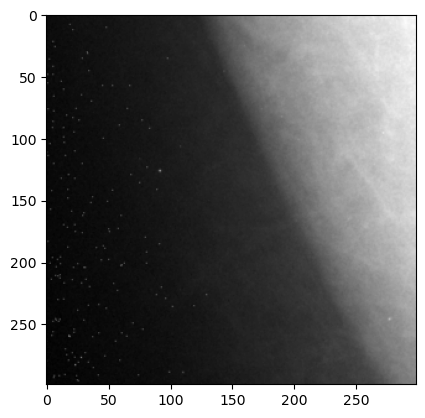

In [11]:
plt.imshow(X[150], cmap="grey")

# Apply Filters

## CLAHE

In [12]:
X_filtered_clahe = apply_clahe_filter_on_all_images(X)

Applying CLAHE filter...: 100%|██████████| 11177/11177 [00:00<00:00, 13641.78it/s]


In [13]:
features_clahe = get_features_from_images(X_filtered_clahe)

Extracting features ...: 100%|██████████| 11177/11177 [29:08<00:00,  6.39it/s]


In [ ]:
# features_clahe = pd.read_csv("features_DDS_CLAHE.csv", sep=";")

## MF&CLAHE&USM

In [ ]:
X_filtered_mf_clahe_usm = apply_MF_and_CLAHE_and_USM_on_all_images(X)

Applying MF & CLAHE & USM...: 100%|██████████| 11177/11177 [03:52<00:00, 48.15it/s]


In [ ]:
features_mf_clahe_usm = get_features_from_images(X_filtered_mf_clahe_usm)

Extracting features ...: 100%|██████████| 11177/11177 [44:08<00:00,  4.22it/s]


In [ ]:
# features_mf_clahe_usm = pd.read_csv("Data/Databases/features_DDS_MF_CLAHE_USM.csv", sep=";")

# Model

## CLAHE

In [40]:
X_train, X_test, y_train, y_test = train_test_split(features_clahe, y, test_size=0.3, random_state=42)

In [41]:
best_params = get_best_hyperparameters_optuna(X_train, y_train, n_trials=200)

[I 2025-02-25 20:25:32,914] A new study created in memory with name: no-name-5ab6ffcd-0cdd-49f3-95dd-e4144f7ef70a
[I 2025-02-25 20:25:33,327] Trial 0 finished with value: 0.8802726885385599 and parameters: {'n_estimators': 50, 'max_depth': 3, 'min_samples_split': 6, 'min_samples_leaf': 4, 'max_features': None}. Best is trial 0 with value: 0.8802726885385599.
[I 2025-02-25 20:25:33,487] Trial 1 finished with value: 0.8951853429910525 and parameters: {'n_estimators': 20, 'max_depth': 19, 'min_samples_split': 10, 'min_samples_leaf': 3, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.8951853429910525.
[I 2025-02-25 20:25:34,969] Trial 2 finished with value: 0.9045590115040477 and parameters: {'n_estimators': 190, 'max_depth': 17, 'min_samples_split': 7, 'min_samples_leaf': 5, 'max_features': 'log2'}. Best is trial 2 with value: 0.9045590115040477.
[I 2025-02-25 20:25:35,539] Trial 3 finished with value: 0.8828291435875586 and parameters: {'n_estimators': 170, 'max_depth': 3, 'min_sa


Meilleurs hyperparamètres trouvés : {'n_estimators': 120, 'max_depth': 17, 'min_samples_split': 6, 'min_samples_leaf': 4, 'max_features': 'sqrt'}
Meilleure accuracy (LOO) : 0.9080


In [42]:
model = RandomForestClassifier(**best_params, random_state=42)

model.fit(X_train, y_train)

RandomForestClassifier(max_depth=17, min_samples_leaf=4, min_samples_split=6,
                       n_estimators=120, random_state=42)

In [43]:
y_pred = model.predict(X_test)

metrics_test = compute_classification_metrics(y_test, y_pred)

Accuracy: 0.912
Sensitivity (Recall): 0.463
Specificity: 0.977
PPV (Precision): 0.742
NPV: 0.927
F1-score: 0.571
AUC: 0.720
Balanced Accuracy: 0.720


## MF&CLAHE&USM

In [35]:
X_train, X_test, y_train, y_test = train_test_split(features_mf_clahe_usm, y, test_size=0.3, random_state=42)

In [37]:
best_params = get_best_hyperparameters_optuna(X_train, y_train, n_trials=200)

[I 2025-02-25 20:21:55,328] A new study created in memory with name: no-name-499c0219-d5e0-401f-b825-154d7b4b5028
[I 2025-02-25 20:21:55,394] Trial 0 finished with value: 0.8832552194290584 and parameters: {'n_estimators': 10, 'max_depth': 2, 'min_samples_split': 7, 'min_samples_leaf': 2, 'max_features': None}. Best is trial 0 with value: 0.8832552194290584.
[I 2025-02-25 20:21:56,585] Trial 1 finished with value: 0.8947592671495527 and parameters: {'n_estimators': 150, 'max_depth': 12, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 1 with value: 0.8947592671495527.
[I 2025-02-25 20:21:56,735] Trial 2 finished with value: 0.8815509160630592 and parameters: {'n_estimators': 10, 'max_depth': 6, 'min_samples_split': 2, 'min_samples_leaf': 5, 'max_features': None}. Best is trial 1 with value: 0.8947592671495527.
[I 2025-02-25 20:21:57,842] Trial 3 finished with value: 0.8926288879420536 and parameters: {'n_estimators': 170, 'max_depth': 8, 'min_sample


Meilleurs hyperparamètres trouvés : {'n_estimators': 90, 'max_depth': 18, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_features': 'log2'}
Meilleure accuracy (LOO) : 0.9016


In [38]:
model = RandomForestClassifier(**best_params, random_state=42)

model.fit(X_train, y_train)

RandomForestClassifier(max_depth=18, max_features='log2', min_samples_split=4,
                       n_estimators=90, random_state=42)

In [39]:
y_pred = model.predict(X_test)

metrics_test = compute_classification_metrics(y_test, y_pred)

Accuracy: 0.901
Sensitivity (Recall): 0.423
Specificity: 0.970
PPV (Precision): 0.673
NPV: 0.921
F1-score: 0.520
AUC: 0.697
Balanced Accuracy: 0.697
